# Preliminary operations

In [1375]:
import pandas as pd
import numpy as np
import copy
import pickle
import os
import itertools
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from math import sqrt
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout, TimeDistributed
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

seed = 123
tf.keras.utils.set_random_seed(seed)

In [1376]:
%run utils.ipynb

In [1377]:
%run preprocessing.ipynb

In [1378]:
%run preparation.ipynb

In [1379]:
%run training_lstm.ipynb

In [1380]:
%run predict.ipynb

In [1381]:
fail = 'flash_mob'
hour = 'peak'
to_train = False

# Loading data

In [1382]:
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
number_of_features = len(df.columns)

In [1383]:
if hour == 'day':
    data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_14400_day.csv'
elif hour == 'night':
    data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_14400_night.csv'
else:
    data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_14400.csv'
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)

In [1384]:
assert len(df.columns) == len(df_fail.columns)

In [1385]:
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: {fail}, Hour: {hour}</sup>"

save_path = 'html_plots/' + fail + '_' + hour + '.html'
fig = px.line(df_fail[3600:-1200], x = df_fail[3600:-1200].index, y = df_fail[3600:-1200].columns, title = title)
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

In [1386]:
title = f"Simulation indicators time series: interactive line plot <br><sup>City: San Francisco, Scenario: normal</sup>"

save_path = 'html_plots/normal.html'
fig = px.line(df[3600:-1200], x = df[3600:-1200].index, y = df[3600:-1200].columns, title = title)
fig.update_layout(legend_title_text = 'Indicators')
fig.write_html(save_path)

# Preprocessing

In [1387]:
# Preprocessing parameters
params = [
    False, # ratio
    False, # smoothing
    False, # collinearity
    False, # log
    300, # aggregation
    False, # statistics
    1, # differencing
    False, # seasonality
    True # normalize
]
scaler_path = f"df_{params[0]}_{params[1]}_{params[2]}_{params[3]}_{params[4]}_{params[5]}_{params[6]}_{params[7]}_{params[8]}"

df_ = copy.deepcopy(df)
df_fail_ = copy.deepcopy(df_fail)

# Apply same preprocessing to train and test
df_proc, scaler = preprocessing(df_,
                        ratio = params[0],
                        smoothing = params[1],
                        collinearity = params[2],
                        log = params[3],
                        aggregation = params[4],
                        statistics = params[5],
                        differencing = params[6],
                        seasonality = params[7],
                        normalize = params[8],
                        load_scaler = False,
                        save = False)
df_proc_fail, scaler_ = preprocessing(df_fail_,
                               ratio = params[0],
                               smoothing = params[1],
                               collinearity = params[2],
                               log = params[3],
                               aggregation = params[4],
                               statistics = params[5],
                               differencing = params[6],
                               seasonality = params[7],
                               normalize = params[8],
                               load_scaler = True,
                               save = False)

(86400, 39)
(9900, 39)


# Preparation

In [1388]:
train_set = preparation(df_proc,
                        window_size = 20,
                        overlap = 0,
                        val_hours = 0)
test_set_fail = preparation(df_proc_fail,
                            window_size = 20,
                            overlap = 0,
                            val_hours = 0)

(4320, 20, 39)
(495, 20, 39)


# Modeling

In [1389]:
# Training
if to_train:
    history, model = training_lstm(train_set,
                                   None,
                                   n_layers_encoder = 1,
                                   n_layers_decoder = 1,
                                   hidden_units = [128, 64, 64, 128],
                                   activation_hidden = 'tanh',
                                   activation_dense = 'sigmoid',
                                   dropout_rate = 0,
                                   learning_rate = 0.001,
                                   n_epochs = 500,
                                   metric = 'mse',
                                   batch_size = 64,
                                   window_size = 20,
                                   plot = True,
                                   save = True)
    
    # Predicting training set
    original, reconstructed = predict(model, train_set, scaler_path, recurrent = True)
    
    # Save plots and df
    num_features = min(train_set.shape[2], len(df.columns))
    mae = save_predict_plots(original, reconstructed, df.columns, num_features, scaler_path, model_type = 'lstm', plot = False, compute_df = True)
    
else:
    model_path = 'models/lstm/1_1_128_128_tanh_sigmoid_0_0001_500_mse_64.pkl'
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

# Predicting failure

In [1390]:
# Setting percentile threshold for the reconstruction error
if to_train:
    percentile_99 = 0.99
    mae_df = pd.read_csv("predictions/lstm/lstm_mae.csv")
    mae_99 = mae_df.quantile(percentile_99)
    mae_99_df = mae_99.reset_index().rename(columns = {'index': 'indicators', percentile_99: 'thresholds'})
    mae_99_df.to_csv('metrics/mae_99.csv', index = False)
else:
    mae_99_df = pd.read_csv("metrics/mae_99.csv").dropna().reset_index(drop = True)

In [1391]:
# Predicting test dataset
original, reconstructed = predict(model, test_set_fail, scaler_path, recurrent = True)

# Save plots and df
num_features = min(test_set_fail.shape[2], len(df_proc_fail.columns))
mae = save_predict_plots(original, reconstructed, df_proc_fail.columns, num_features, scaler_path, model_type = 'lstm_fail', plot = False, compute_df = True)

16/16 [==============================] - 1s 8ms/step
Mean MAE: 0       0.013692
1       0.015656
2       0.016068
3       0.015345
4        0.01522
          ...   
9895    0.040087
9896    0.040521
9897    0.039058
9898    0.039982
9899    0.040666
Length: 9900, dtype: object


In [1392]:
# Loading metrics datasets
mae_fail_df = pd.read_csv("predictions/lstm_fail/lstm_fail_mae.csv")
mae_fail_df = mae_fail_df[320:].dropna().reset_index(drop = True)
#rmse_fail_df = pd.read_csv("predictions/lstm_fail/lstm_fail_rmse.csv")
#rmse_fail_df = rmse_fail_df[320:].dropna().reset_index(drop = True)

# Computing failed_requests index
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)
for column in df_fail.columns:
    df_fail[column] = np.around(df_fail[column].astype(float), 5)
    df_fail[column] = df_fail[column].rolling(window = 300).mean()
df_fail = df_fail[3600:-900].reset_index(drop = True)
failed_requests_fail = [0] * len(df_fail)
w_failed_requests_fail = [0] * len(df_fail)
factor = df['rides_requested'].mean()
for i in range(0, len(df_fail)):
    if df_fail['rides_requested'][i] == 0:
        failed = 0
        w_failed = 0
    else:
        failed, w_failed = compute_failed_requests(float(df_fail['rides_not_served'][i]) + float(df_fail['rides_canceled'][i]), float(df_fail['rides_requested'][i]), factor)
    failed_requests_fail[i] = failed
    w_failed_requests_fail[i] = w_failed
    
# Setting thresholds
failed_requests_fail = pd.Series(failed_requests_fail)
threshold = 0.5
green_line_timestamp = 0
#exceed_indexes = failed_requests_fail[failed_requests_fail >= threshold]
for i in range(3600, len(failed_requests_fail) - 20 + 1):
    window = failed_requests_fail[i:i+20]
    # Calculate the percentage of observations >= threshold
    percentage = sum(value >= threshold for value in window) / 20
    if percentage >= threshold:
        # Return the index of the first observation in the window meeting the criteria
        green_line_timestamp = window.index[0]
        break

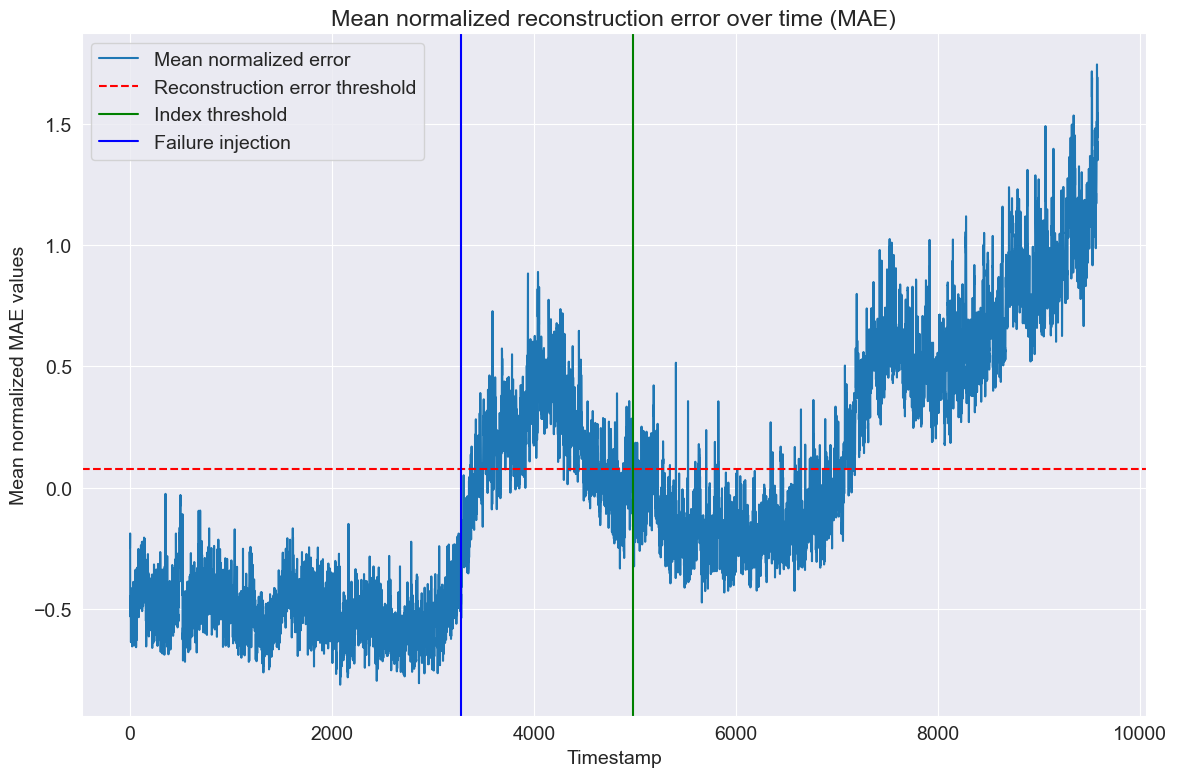

Failure (50%) predicted 1615 timestamps in advance.


In [1393]:
# Plot final results (MAE)
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mae_fail_df.index)
normalized_thresholds_99 = []

for indicator in mae_fail_df.columns:
    errors = mae_fail_df[indicator]
    if errors.std() == 0:
        stdev_err = 1
    else:
        stdev_err = errors.std()
    
    # Normalize errors
    normalized_errors = (errors - errors.mean()) / stdev_err
    mean_normalized_errors[indicator] = normalized_errors
    
    # Normalize the threshold
    threshold = mae_99_df[mae_99_df['indicators'] == indicator]['thresholds'].values[0]
    normalized_threshold = (threshold - errors.mean()) / stdev_err
    normalized_thresholds_99.append(normalized_threshold)

mean_normalized_threshold_99 = np.mean(normalized_thresholds_99)
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)
exceeds_threshold_filtered_99 = mean_normalized_errors[mean_normalized_errors.index >= 3000]['mean_error'] > mean_normalized_threshold_99
first_exceed_timestamp_99 = exceeds_threshold_filtered_99.idxmax() if exceeds_threshold_filtered_99.any() else None
timestamp_difference_50 = 0
#timestamp_difference_70 = 0
#timestamp_difference_90 = 0
try:
    if first_exceed_timestamp_99:
        if green_line_timestamp != 0:
            timestamp_difference_50 = green_line_timestamp - first_exceed_timestamp_99
        else:
            timestamp_difference_50 = 0
        #if len(green_line_timestamps) > 1:
        #    timestamp_difference_70 = green_line_timestamps[1] - first_exceed_timestamp_99
        #if len(green_line_timestamps) > 2:
        #    timestamp_difference_90 = green_line_timestamps[2] - first_exceed_timestamp_99
    
    plt.figure()
    plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
    plt.axhline(y = mean_normalized_threshold_99, color = 'red', linestyle = '--', label = f'Reconstruction error threshold')
    if green_line_timestamp != 0:
        plt.axvline(x = green_line_timestamp, color = 'green', label = 'Index threshold')
    plt.axvline(x = 3280, color = 'blue', label = 'Failure injection')
    plt.title('Mean normalized reconstruction error over time (MAE)')
    plt.xlabel('Timestamp')
    plt.ylabel('Mean normalized MAE values')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.savefig('results/' + fail + '_' + hour + '_MAE_' + str(timestamp_difference_50) + '.png', dpi = 300)
    plt.show()
    
    if timestamp_difference_50 > 0:
        print(f"Failure (50%) predicted {timestamp_difference_50} timestamps in advance.")
    elif timestamp_difference_50 == 0:
        print(f"Failure not predicted")
    else:
        print(f"Failure (50%) predicted {timestamp_difference_50} timestamps late.")
except:
    print("Not a failure")

In [ ]:
'''
# Plot final results (RMSE)
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = rmse_fail_df.index)
normalized_thresholds_99 = []

for indicator in rmse_fail_df.columns:
    errors = rmse_fail_df[indicator]
    if errors.std() == 0:
        stdev_err = 1
    else:
        stdev_err = errors.std()
    
    # Normalize errors
    normalized_errors = (errors - errors.mean()) / stdev_err
    mean_normalized_errors[indicator] = normalized_errors
    
    # Normalize the threshold
    threshold = rmse_99_df[rmse_99_df['indicators'] == indicator]['thresholds'].values[0]
    normalized_threshold = (threshold - errors.mean()) / stdev_err
    normalized_thresholds_99.append(normalized_threshold)

mean_normalized_threshold_99 = np.mean(normalized_thresholds_99)
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)
exceeds_threshold_filtered_99 = mean_normalized_errors[mean_normalized_errors.index >= 3000]['mean_error'] > mean_normalized_threshold_99
first_exceed_timestamp_99 = exceeds_threshold_filtered_99.idxmax() if exceeds_threshold_filtered_99.any() else None
timestamp_difference_50 = 0
#timestamp_difference_70 = 0
#timestamp_difference_90 = 0
try:
    if first_exceed_timestamp_99:
        timestamp_difference_50 = green_line_timestamps[0] - first_exceed_timestamp_99
        #if len(green_line_timestamps) > 1:
        #    timestamp_difference_70 = green_line_timestamps[1] - first_exceed_timestamp_99
        #if len(green_line_timestamps) > 2:
        #    timestamp_difference_90 = green_line_timestamps[2] - first_exceed_timestamp_99
    
    plt.figure()
    plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
    plt.axhline(y = mean_normalized_threshold_99, color = 'red', linestyle = '--', label = f'Reconstruction error threshold')
    plt.axvline(x = green_line_timestamp, color = 'green', label = 'Index threshold')
    plt.title('Mean normalized reconstruction error over time (RMSE)')
    plt.xlabel('Timestamp')
    plt.ylabel('Mean normalized RMSE values')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.savefig('results/' + fail + '_' + hour + '_RMSE_' + str(timestamp_difference_50) + '.png', dpi = 300)
    plt.show()
    
    if timestamp_difference_50 > 0:
        print(f"Failure (50%) predicted {timestamp_difference_50} timestamps in advance.")
    else:
        print(f"Failure not predicted")
except:
    print("Not a failure")
'''

In [1208]:
'''
# Plot final results (MAPE)
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 14})

mean_normalized_errors = pd.DataFrame(index = mape_fail_df.index)
normalized_thresholds_99 = []

for indicator in mape_fail_df.columns:
    errors = mape_fail_df[indicator]
    if errors.std() == 0:
        stdev_err = 1
    else:
        stdev_err = errors.std()
    
    # Normalize errors
    normalized_errors = (errors - errors.mean()) / stdev_err
    mean_normalized_errors[indicator] = normalized_errors
    
    # Normalize the threshold
    threshold = mape_99_df[mape_99_df['indicators'] == indicator]['thresholds'].values[0]
    normalized_threshold = (threshold - errors.mean()) / stdev_err
    normalized_thresholds_99.append(normalized_threshold)

mean_normalized_threshold_99 = np.mean(normalized_thresholds_99)
mean_normalized_errors['mean_error'] = mean_normalized_errors.mean(axis = 1)
exceeds_threshold_filtered_99 = mean_normalized_errors[mean_normalized_errors.index >= 3000]['mean_error'] > mean_normalized_threshold_99
first_exceed_timestamp_99 = exceeds_threshold_filtered_99.idxmax() if exceeds_threshold_filtered_99.any() else None
timestamp_difference_50 = 0
#timestamp_difference_70 = 0
#timestamp_difference_90 = 0
try:
    if first_exceed_timestamp_99:
        timestamp_difference_50 = green_line_timestamps[0] - first_exceed_timestamp_99
        #if len(green_line_timestamps) > 1:
        #    timestamp_difference_70 = green_line_timestamps[1] - first_exceed_timestamp_99
        #if len(green_line_timestamps) > 2:
        #    timestamp_difference_90 = green_line_timestamps[2] - first_exceed_timestamp_99
    
    plt.figure()
    plt.plot(mean_normalized_errors.index, mean_normalized_errors['mean_error'], label = 'Mean normalized error')
    plt.axhline(y = mean_normalized_threshold_99, color = 'red', linestyle = '--', label = f'Reconstruction error threshold')
    plt.axvline(x = green_line_timestamp, color = 'green', label = 'Index threshold')
    plt.title('Mean normalized reconstruction error over time (MAPE)')
    plt.xlabel('Timestamp')
    plt.ylabel('Mean normalized MAPE values')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.savefig('results/' + fail + '_' + hour + '_MAPE_' + str(timestamp_difference_50) + '.png', dpi = 300)
    plt.show()
    
    if timestamp_difference_50 > 0:
        print(f"Failure (50%) predicted {timestamp_difference_50} timestamps in advance.")
    else:
        print(f"Failure not predicted")
except:
    print("Not a failure")
'''

'\n# Plot final results (MAPE)\nplt.rcParams["figure.figsize"] = (12, 8)\nplt.rcParams.update({\'font.size\': 14})\n\nmean_normalized_errors = pd.DataFrame(index = mape_fail_df.index)\nnormalized_thresholds_99 = []\n\nfor indicator in mape_fail_df.columns:\n    errors = mape_fail_df[indicator]\n    if errors.std() == 0:\n        stdev_err = 1\n    else:\n        stdev_err = errors.std()\n    \n    # Normalize errors\n    normalized_errors = (errors - errors.mean()) / stdev_err\n    mean_normalized_errors[indicator] = normalized_errors\n    \n    # Normalize the threshold\n    threshold = mape_99_df[mape_99_df[\'indicators\'] == indicator][\'thresholds\'].values[0]\n    normalized_threshold = (threshold - errors.mean()) / stdev_err\n    normalized_thresholds_99.append(normalized_threshold)\n\nmean_normalized_threshold_99 = np.mean(normalized_thresholds_99)\nmean_normalized_errors[\'mean_error\'] = mean_normalized_errors.mean(axis = 1)\nexceeds_threshold_filtered_99 = mean_normalized_err